In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import pickle
import pynbody

mpl.rc('font',**{'family':'serif','monospace':['Palatino']})
mpl.rc('text', usetex=True)
plt.rcParams['figure.constrained_layout.use'] = False
mpl.rcParams.update({'font.size': 9})

In [2]:
# it is convenient to define these functions to read in our datasets for us

def read_z0(simname):
    '''Function to read in the data file which contains z=0 information for the various halos.'''
    data = []
    with open('../../Data/z0_data/'+ simname + '.data', 'rb') as f:
        while True:
            try:
                data.append(pickle.load(f,encoding='latin1'))
            except EOFError:
                break

    data1 = pd.DataFrame(data)
    return data1
    
def read_timesteps(simname):
    '''Function to read in the timestep bulk-processing datafile (from /home/akinhol/Data/Timescales/DataFiles/{name}.data)'''
    data = []
    with open(f'../../Data/timesteps_data/{simname}.data','rb') as f:
        while True:
            try: 
                data.append(pickle.load(f))
            except EOFError:
                break
    
    data = pd.DataFrame(data)
    return data

def read_infall_properties():
    '''Function to read in the data file with quenching timescales and satellite properties at infall.'''
    data = []
    with open(f'../../Data/QuenchingTimescales_InfallProperties.data','rb') as f:
        while True:
            try: 
                data.append(pickle.load(f))
            except EOFError:
                break
            
    data = pd.DataFrame(data)
    data['timescale'] = data.tinfall - data.tquench
    
    return data

In [145]:
names = ['h148','h242','h229','h329']
age = 13.800797497330507
rquench = np.array([])
tquench = np.array([])
tinfall = np.array([])
sims = np.array([])
hids = np.array([])
for name in names:
    print(f'Simulation {name}')

    z0_all = read_z0(name) # the datasets for the simulation as a whole
    timesteps_all = read_timesteps(name)

    haloids = np.unique(np.array(timesteps_all.z0haloid, dtype=int)) # all the unique haloids we're interested in

    for haloid in haloids: # for each satellite
        z0 = z0_all[z0_all.haloid==haloid] # the datasets with *just this specific satellite*, a subset of the datasets previously defined
        timesteps = timesteps_all[np.array(timesteps_all.z0haloid,dtype=int)==haloid]

        # get the quenching time
        sfr = np.array(timesteps.sfr,dtype=float)
        mstar = np.array(timesteps.mstar,dtype=float)
        dist = np.array(timesteps.h1dist,dtype=float)
        time = np.array(timesteps.time,dtype=float)

        sfr = sfr[np.argsort(time)]
        mstar = mstar[np.argsort(time)]
        dist = dist[np.argsort(time)]
        time = np.sort(time)

        sSFR = sfr/mstar
        lbt = 13.8007 - time

        is_quenched = z0.sSFR.tolist()[0] < q_thresh # boolean expression to determine whether the satellite is quenched
        # is its z=0 sSFR below the threshold? 

        if is_quenched:
            # then the halo is quenched, so we calculate the quenching time
            for i in range(0,len(lbt)):
                t = np.flip(lbt)[i]
                s = np.flip(sSFR)[i]
                r = np.flip(dist)[i]
                if s > 1e-11:
                    #print(f'\t Halo {haloid}, quenched {t:.2f} Gyr ago at radius {r:.2f} kpc')
                    rq = r
                    tq = t
                    break
                else:
                    continue      
        else:
            #print(f'\t Halo {haloid}, unquenched at z = 0')
            tq, rq = None, None
            
        dist = np.array(timesteps.h1dist,dtype=float)
        time = age - np.array(timesteps.time, dtype=float) # in Gyr ago

        try:
            ti = np.max(time[dist <= i_thresh]) 
            #print(f'\t Halo {haloid}, infall {ti} Gyr ago')
        except ValueError:
            #print(f'\t Halo {haloid}, never infell')
            ti = None

        rquench = np.append(rquench,rq)
        tquench = np.append(tquench,tq)
        tinfall = np.append(tinfall,ti)
        sims = np.append(sims,name)
        hids = np.append(hids,haloid)


Simulation h148


/Users/hollis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Simulation h242
Simulation h229
Simulation h329


In [146]:
condition = (rquench != None) & (tquench != None) 
rq2 = rquench[condition]
ti2 = tinfall[condition]
tq2 = tquench[condition]
sims2 = sims[condition]
hids2 = hids[condition]

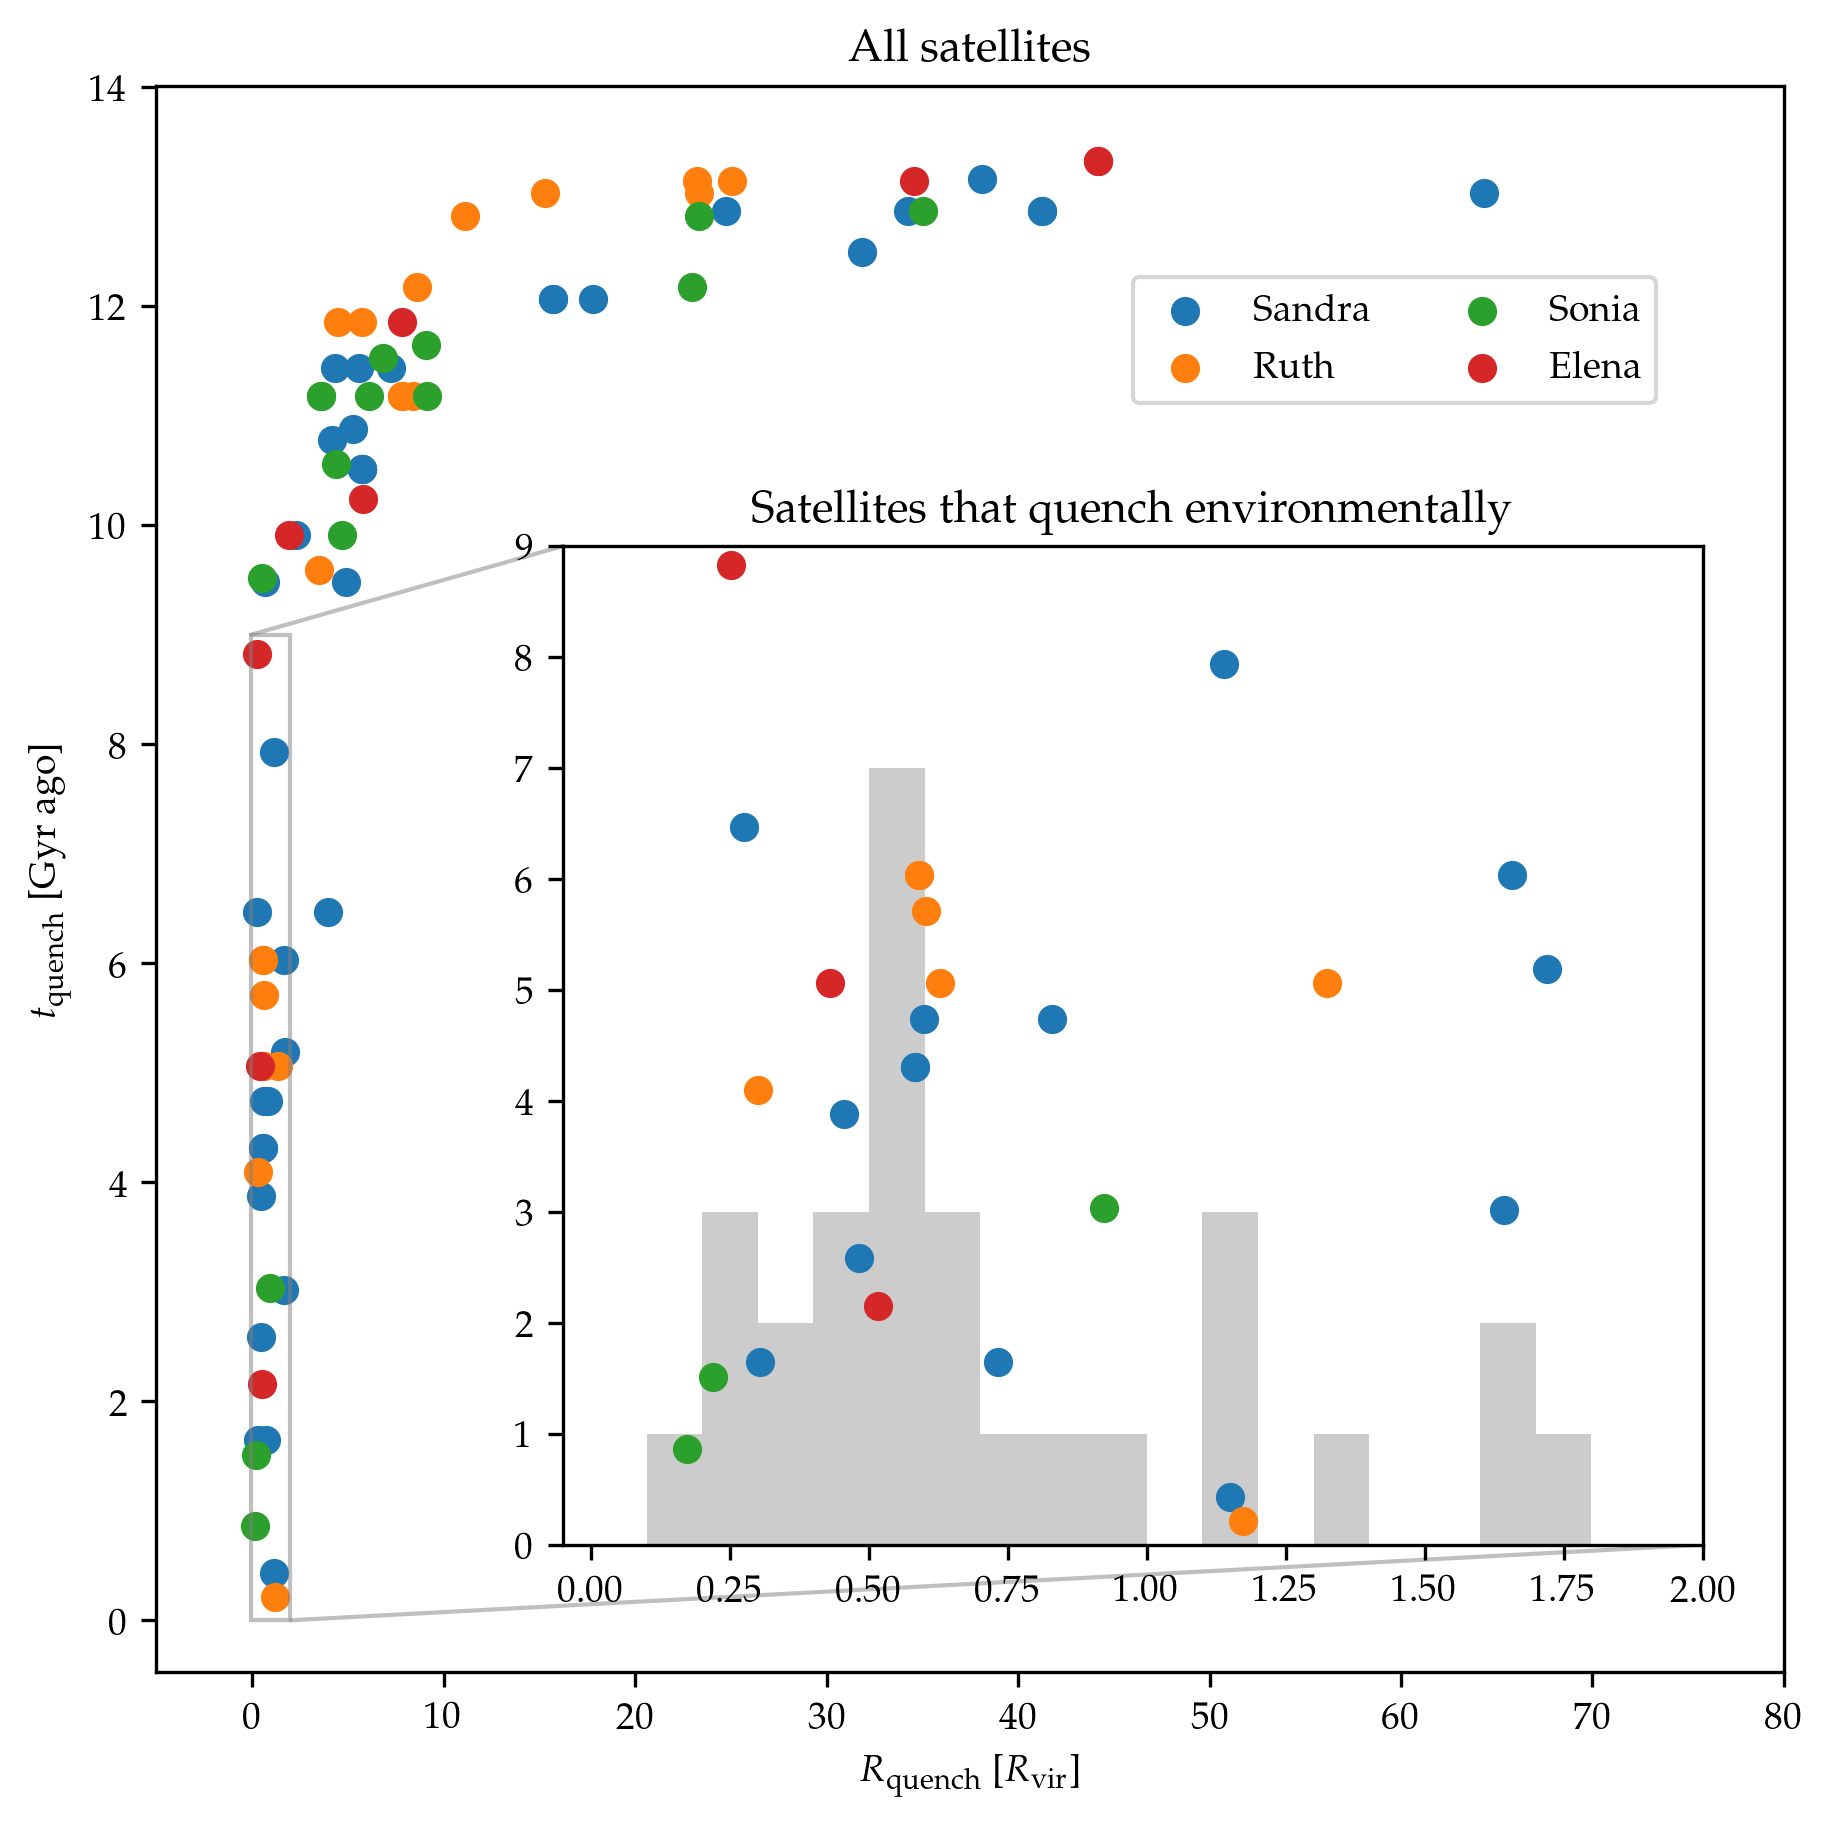

In [162]:
fig, ax = plt.subplots(1,1,figsize=(7,7),dpi=300)
ax.scatter(rq2[sims2=='h148'],tq2[sims2=='h148'], label='Sandra')
ax.scatter(rq2[sims2=='h229'],tq2[sims2=='h229'], label='Ruth')
ax.scatter(rq2[sims2=='h242'],tq2[sims2=='h242'], label='Sonia')
ax.scatter(rq2[sims2=='h329'],tq2[sims2=='h329'], label='Elena')
ax.set_xlabel(r'$R_{\rm quench}$ [$R_{\rm vir}$]')
ax.set_ylabel(r'$t_{\rm quench}$ [Gyr ago]')
ax.legend(ncol=2, loc=(0.6,0.8))
ax.set_xlim(-5,80)

ax2 = ax.inset_axes([0.25,0.08,0.7,0.63])

ax2.scatter(rq2[sims2=='h148'],tq2[sims2=='h148'], label='Sandra')
ax2.scatter(rq2[sims2=='h229'],tq2[sims2=='h229'], label='Ruth')
ax2.scatter(rq2[sims2=='h242'],tq2[sims2=='h242'], label='Sonia')
ax2.scatter(rq2[sims2=='h329'],tq2[sims2=='h329'], label='Elena')
ax2.set_xlim(-0.05,2)
ax2.set_ylim(0,9)
ax2.hist(rq2, bins=np.arange(0,2,0.1), zorder=-1, color='k', alpha=0.2)

ax2.set_title('Satellites that quench environmentally')
ax.set_title('All satellites')
ax.indicate_inset_zoom(ax2)

plt.savefig('r_quench.png',dpi=300)
plt.show()


In [76]:
print(sims2[(rq2 > 3)&(rq2 < 5)])
print(hids2[(rq2 > 3)&(rq2 < 5)])

['h148' 'h148' 'h148' 'h148' 'h242' 'h242' 'h242' 'h242' 'h229' 'h229']
[ 30. 128. 384. 386.  30.  34.  40.  78.  53. 113.]


[4.666439108378722]
[1.5084313316065892]
[9.912451252402938]
1.08e+06


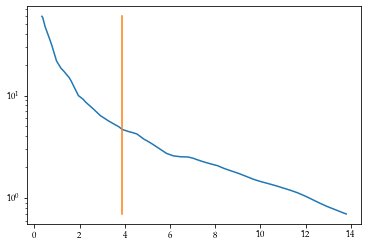

In [93]:
sim,i = 'h242',40

data = read_timesteps(sim)
data = data[data.z0haloid==i]

print(rquench[(sims==sim)&(hids==i)])
print(tinfall[(sims==sim)&(hids==i)])
print(tquench[(sims==sim)&(hids==i)])

print(f'{data.mstar[np.argmin(data.z)]:.2e}')
plt.plot(data.time, data.h1dist)
plt.plot([age-tquench[(sims==sim)&(hids==i)][0]]*2,[np.min(data.h1dist), np.max(data.h1dist)])
plt.semilogy()
plt.show()

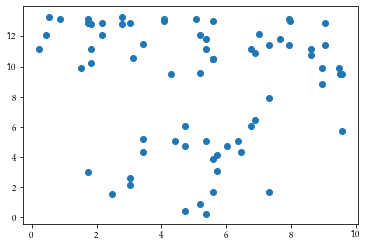

In [95]:
plt.scatter(tinfall,tquench)

In [47]:
data = read_timescales()
rquench = rquench[(~np.isnan(np.array(data.tinfall,dtype=float)))&(data.n_star > 50)]

In [50]:
data = read_infall_properties()
data['rquench'] = rquench
q = data[(data.tquench < 9.5)&(data.timescale > -2)] 
quenched = np.array(data.quenched,dtype=bool)
sf = data[~quenched]
data = q.append(sf)
quenched = np.array(data.quenched,dtype=bool)
tinfall = np.array(data.tinfall)
timescale = np.array(data.timescale)
timescale[~quenched] = tinfall[~quenched]



plt.hist(data.rquench[~np.isnan(rquench)])

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

100

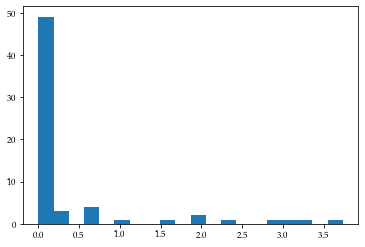

In [16]:
plt.hist(rquench[rquench < 5], bins=20)
plt.show()

In [18]:
np.mean(rquench[rquench < 2])

0.19930958489389244

In [22]:
np.median(rquench[rquench < 2])

0.028970079508611635